In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from featimp import *
import matplotlib.pyplot as plt

# Feature Importance

## Overview

Feature importance is a very important in today's data science paradigm as it can greatly impact model perform as well as provide useful insights. In my report I will be discussing some current trends in the data science industry for computing feature importance.

Feature importance calculation methods fall into two main categories. First, we have methods that work directly from the data itself. On the other hand, there are also model based strategies for determining how useful a feature is.

# Importance Strategies Working Directly From the Data

## Spearman's Rank Correlation Coefficient

One of the simplest techniques to compute feature importance is using Spearman's rank correlation coefficient. For this method, we calculate the coefficients for each feature and rank them from largest to smallest, with the largest being the most important.  This method is considered to measure "single-feature relevance" and works well with independent features.  It however can struggle in the presence of codependent features. This is because similar features will receive similar correlation coefficients to each other, even though only one should be considered important for the model.

To illustrate some of the algorithms in this report, we will be using the well known automobile mpg dataset, where we are trying to use a car's charecteristics to predict its mpg.  
In the graph below, we can see that Spearman's correlation coefficient indicates weight to be the most important variable.

In [2]:
automobile_df = pd.read_csv('auto-mpg.csv')
automobile_df = automobile_df[automobile_df['horsepower'] != '?']
automobile_df.drop('car name', inplace=True, axis=1)
automobile_df['horsepower'] = automobile_df['horsepower'].astype(int)

In [3]:
columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
target = 'mpg'
importances = []
for col in columns:
    importances.append(spearman_rank(automobile_df, target, col))

In [4]:
spearman_importances = pd.DataFrame({'feature':columns, 'p':importances})

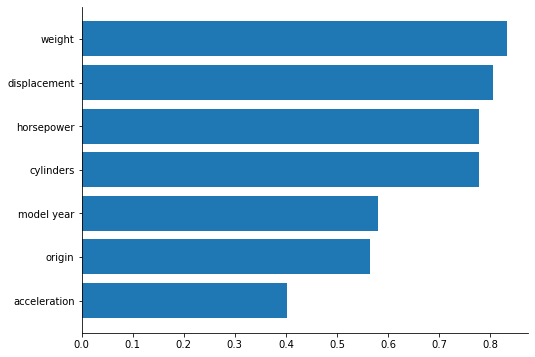

In [5]:
spearman_importances.sort_values('p', inplace=True)
x = spearman_importances['feature']
y = spearman_importances['p']
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### PCA

Another data based method for feature importance is using principle component analysis (PCA). PCA is different from Spearman's in that it does not look at the response variable at all. PCA transforms data into a different space of vectors and identifies features that explain the most variance. We can look at the first principal component if it explains enough variance and see which variables are the most important inside.

Using PCA it seems that displacement is the most important variable and model year was the least important variable.

In [7]:
pca_importance = pd.DataFrame(pca_features(automobile_df, columns, 5)).T.reset_index().rename({'index':'feature', 0:'score'}, axis=1)

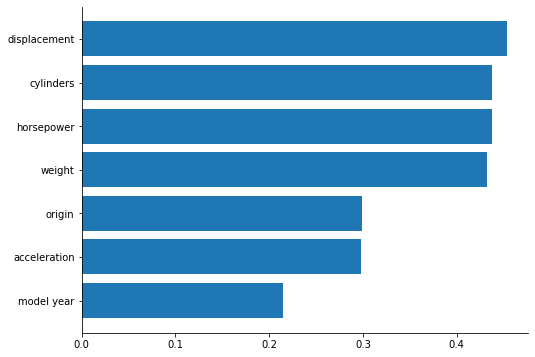

In [8]:
pca_importance.sort_values('score', inplace=True)
x = pca_importance['feature']
y = pca_importance['score']
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

# Model-based impoortance strategies

## Permutation Importance

Moving on to model based strategies, we have permutation importance. Before going into the algorithm, I want to highlight one of the current inefficiencies in today's feature importance calculations. Currently, the default feature importance for random forest in sklearn is calculated using gini drop. This means they are keeping track of which variables accumulate the most drops in terms of gini. The problem with this approach is that it is biased towards high cardinality or continuous features.

The algorithm for permutation importance is as follows:
1. Compute validation metric for model trained on all features
2. Shuffle the data in column x in validation set
3. Recompute validation metric
4. Importance score is the change in metric.

The reasoning behing permutation importance is that if a column is important, making that column random should cause a lot of randomness, thus important.  

For our dataset, we can actually observe that car year is now the most important variable now.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(automobile_df[columns], automobile_df['mpg'], test_size=0.2, random_state=23)

In [10]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [11]:
permutation_importances = pd.DataFrame({'feature':columns, 'score':permutation_importance(model, X_test, y_test)})

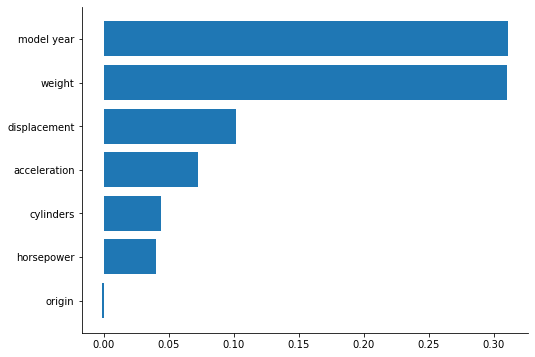

In [12]:
permutation_importances.sort_values('score', inplace=True)
x = permutation_importances['feature']
y = permutation_importances['score']
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Drop Column Importance

Drop column importance is a similar algorithm to permutation but drops column x instead of shuffling it. The algorithm is as follows:
1. Compute validation metric for a model trained on all features.
2. Drop column x from training set.
3. Retrain the model
4. Recompute the validation metric
5. Importance score is the change in metric 

The drop importance method also shows that model year is the most important feature.

In [13]:
model = xgb.XGBRegressor()
drop_column_importances = pd.DataFrame({'feature':columns,
                                        'score':drop_column_importance(model, X_train, y_train, X_test, y_test)})

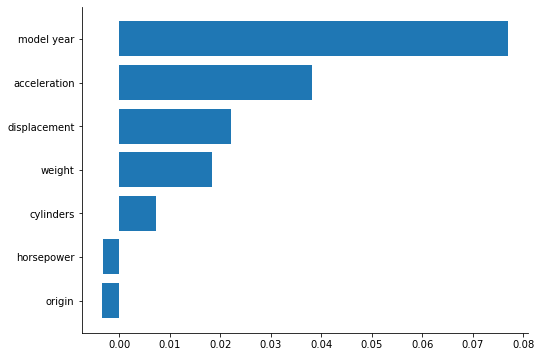

In [14]:
drop_column_importances.sort_values('score', inplace=True)
x = drop_column_importances['feature']
y = drop_column_importances['score']
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Automatic Feature Selection Algorithm

Now that we are familiar with different feature importance algorithms, how can we use these to actually select our features? I wrote a function that automates this process. The algorith goes:
1. Gets a baseline validation metric
2. Computes the feature importances using the specified method
3. Drop the least important variable and retrain the model.
4. Recompute the validation metric.
5. If the validation metric is worse, then we reverse the drop and return the columns we have
6. If the validation metric is not worse, then we continue by dropping the next worse column and repeating this process until the validation metric worsens.

In [18]:
model = xgb.XGBRegressor()
auto_feature_select(model, automobile_df[columns], automobile_df['mpg'], method='drop_column')

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year'],
      dtype='object')

After running the auto feature select function, we are returned with all of the columns except for origin.

# Conclusion

Feature importance is a very interesting subject and there are many new developments constantly being developed. I hope that this article introduced you to some new techniques and will help you in your data science journey. Feel free to check out the code for the implementations in this report in the associated file in this repository.